In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

env_1_sale_args['num_products'] = 10
num_products = env_1_sale_args['num_products']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

env_1_sale_args['number_of_flips'] = 5

## Build targets

In [2]:
## Clicks
from recogym.agents.sale_agent import ClickRewardProvider
Click_rewards = ClickRewardProvider()

## MDP
from recogym.agents.sale_agent import MDPRewardProvider
MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
MDP_rewards_pureorganic = MDPRewardProvider(clicks_only=False, organic_only=True)

rewards = {'click':Click_rewards,
          'MDP':MDP_rewards,
          'MDP_all':MDP_rewards_all,
          'MDP_pureorganic':MDP_rewards_pureorganic}

## Build features

In [3]:
from recogym.agents.sale_agent import CountViewsClicksFeatureProvider, CountViewsFeatureProvider, ShareViewsClicksFeatureProvider, ShareViewsFeatureProvider
vc_feature = CountViewsClicksFeatureProvider(env.config)
v_feature = CountViewsFeatureProvider(env.config)
vc_share_feature = ShareViewsClicksFeatureProvider(env.config)
v_share_feature = ShareViewsFeatureProvider(env.config)

features = {'vc':vc_feature,
           'v':v_feature,
           'vc_share':vc_share_feature,
           'v_share':v_share_feature}

## Train baseline agents

In [6]:
# Choose number of users for training and AB test
env_1_sale_args['num_users'] = 5000
env_1_sale_args['num_users_AB'] = 500
num_users = env_1_sale_args['num_users']
num_users_AB = env_1_sale_args['num_users_AB']

# Choose features
feature_name = 'v_share'
feature = features[feature_name]

In [8]:
from recogym.agents.sale_agent import build_train_data
from recogym.agents.sale_agent import SaleLikelihoodAgent, SaleProductLikelihoodAgent

agents={}
logs={}

############## Random agent
from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))
name_agent = 'rand'
agents[name_agent] = random_agent
try:
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except :
    data = deepcopy(env).generate_logs(num_users)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data
    
############## Organic agent
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
                                                                    **env_1_sale_args,
                                                                    'select_randomly': True}))
name_agent = 'organic'
agents[name_agent] = organic_counter_agent
try:
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except :
    data = deepcopy(env).generate_logs(num_users,agent=organic_counter_agent)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data
    
# ############## Likelihood click
# name_agent = "likclick"
# try :
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except:
#     likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards)
#     likelihood_logreg_click.train(data)
#     agents[name_agent] = likelihood_logreg_click
#     data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data

############## Likelihood click kronecker
name_agent = "likclickkron"
try :
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except:
    likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards,kronecker_features=True)
    likelihood_logreg_click.train(data)
    agents[name_agent] = likelihood_logreg_click
    data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:17:07<00:00,  2.37s/it]


In [ ]:
# create logging policy with exploration
exploration = pkl.load(open(str('data\data'+str(5000)+"rand"+'.pkl'),'rb'))
exploration = exploration.loc[exploration["u"]<1250]
exploration["u"] = exploration["u"] + 1250
print(len(exploration["u"].unique()))
data_ext = pd.concat([data,exploration])
# pkl.dump(data_ext,open(str('data\data'+str(num_users)+name_agent+'explore.pkl'),'wb'))

In [9]:
# name_agent = "rand"
# data = pkl.load(open(str('data\data'+str(15000)+name_agent+'.pkl'),'rb'))
# data = data.loc[data['u']<num_users]
# print(data["u"].unique())
# pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))

<IntegerArray>
[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
 ...
 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999]
Length: 5000, dtype: UInt16


In [10]:
# name_agent = "organic"
# data = pkl.load(open(str('data\data'+str(15000)+name_agent+'.pkl'),'rb'))
# data = data.loc[data['u']<num_users]
# print(data["u"].unique())
# pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))

<IntegerArray>
[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
 ...
 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999]
Length: 5000, dtype: UInt16


## Random logging policy

In [41]:
def train_agents(name_logging,logs,feature_name,features, kronecker_features=False):
    info = {}
    save_agents = {}
    data = logs[name_logging]
    feature = features[feature_name]
    
    if kronecker_features==True:
        print("Kronecker features")
        name_extension = 'kron'
    else:
        name_extension = ''
    
    # click agent
    print("Click agent")
    likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards,
                                                 kronecker_features = kronecker_features)
    likelihood_logreg_click.train(data)
    info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info
    save_agents["likelihood_logreg_click"+name_extension] = likelihood_logreg_click
    
    # No discount
    print("No discount")
    likelihood_saleclickprod_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_all.train(data)
    info[likelihood_saleclickprod_all.info["Name"]] = likelihood_saleclickprod_all.info
    save_agents["likelihood_saleclickprod_all"+name_extension] = likelihood_saleclickprod_all
    
    # No discount
    likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards], 
                                                    discounts=[0,0],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod.train(data)
    info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info
    save_agents["likelihood_saleclickprod"+name_extension] = likelihood_saleclickprod
    
    # non-specific discount, all observations
    print("Non specific discount")
    likelihood_saleclickprod_discount_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_all.train(data)
    info[likelihood_saleclickprod_discount_all.info["Name"]] = likelihood_saleclickprod_discount_all.info
    save_agents["likelihood_saleclickprod_discount_all"+name_extension] = likelihood_saleclickprod_discount_all
    
    # non-specific discount, clicked observations
    likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount.train(data)
    info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info
    save_agents["likelihood_saleclickprod_discount"+name_extension] = likelihood_saleclickprod_discount
    
    # Per product discount, all observations
    print("Specific discount")
    likelihood_saleclickprod_discount_spe_all = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_spe_all.train(data)
    info[likelihood_saleclickprod_discount_spe_all.info["Name"]] = likelihood_saleclickprod_discount_spe_all.info
    save_agents["likelihood_saleclickprod_discount_spe_all"+name_extension] = likelihood_saleclickprod_discount_spe_all
    
    # Per product discount, clicked observations
    likelihood_saleclickprod_discount_spe = SaleProductLikelihoodAgent(feature_provider_list=[feature,feature,feature], 
                                                    reward_provider_list=[Click_rewards,MDP_rewards,MDP_rewards_pureorganic], 
                                                    discounts=[0,0,-1],discounts_with_action=False,
                                                    kronecker_features = kronecker_features)
    likelihood_saleclickprod_discount_spe.train(data)
    info[likelihood_saleclickprod_discount_spe.info["Name"]] = likelihood_saleclickprod_discount_spe.info
    save_agents["likelihood_saleclickprod_discount_spe"+name_extension] = likelihood_saleclickprod_discount_spe
    
    pkl.dump([info,save_agents],open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'wb'))
    return info, save_agents

## tests to understand what's happening

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [02:03<00:00,  1.13s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:06<00:00,  1.70s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:25<00:00,  1.87s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:37<00:00,  1.98s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [04:16<00:00,  2.33s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 110/110 [05:27<00:00,  2.97s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

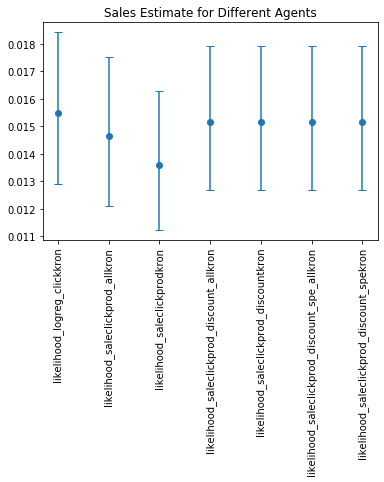

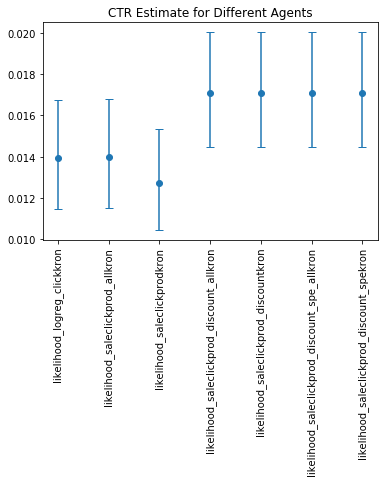

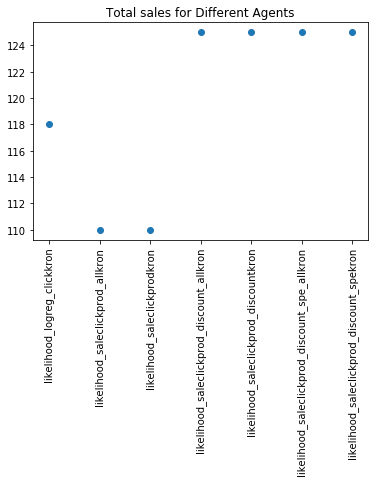

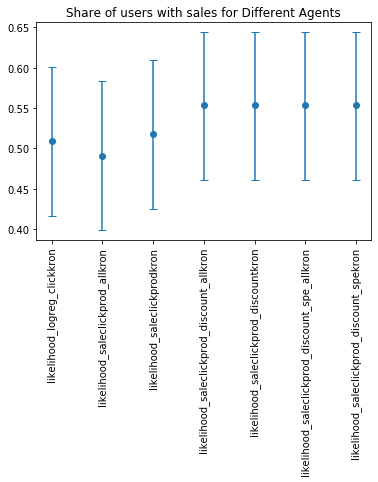

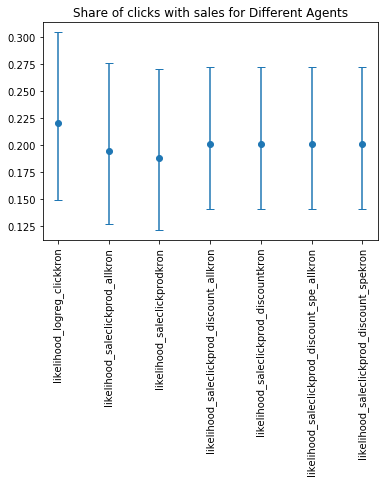

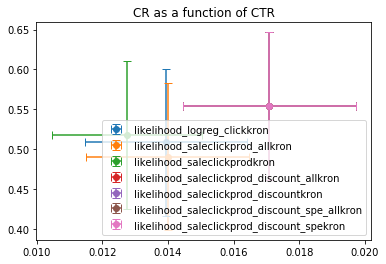

In [45]:
# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [46]:
dico = res_dict[ 'rand100_110_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[7, 8, 5, 2, 3, 0, 6, 9, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprod_allkron
<IntegerArray>
[7, 9, 5, 2, 8, 0, 3, 6, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[7, 4, 5, 8, 0, 6, 2, 3, 9]
Length: 9, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[0]
Length: 1, dtype: UInt16


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [01:48<00:00,  1.21s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:19<00:00,  1.55s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:43<00:00,  1.81s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:33<00:00,  1.71s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:32<00:00,  1.70s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 90/90 [02:35<00:00,  1.73s/it]


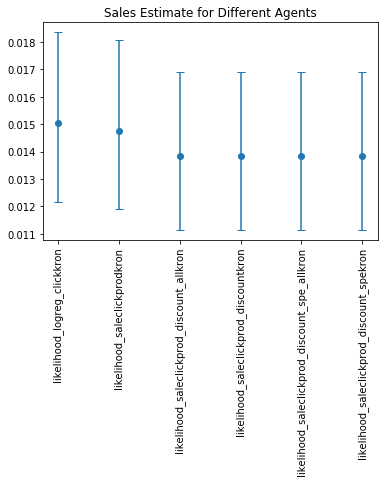

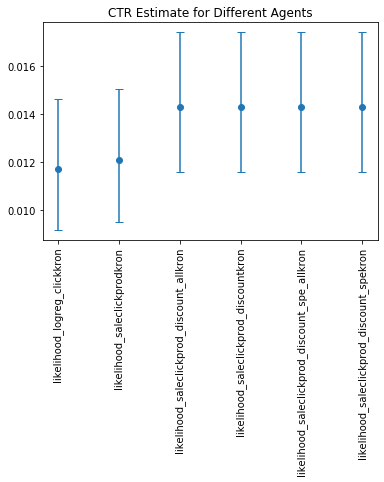

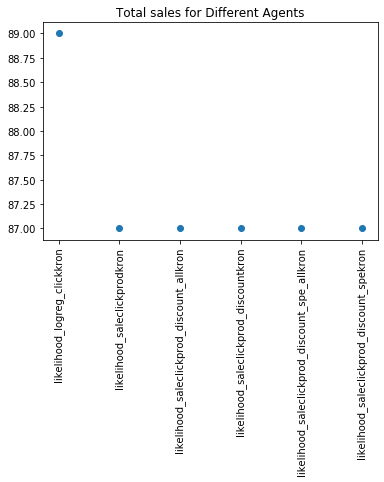

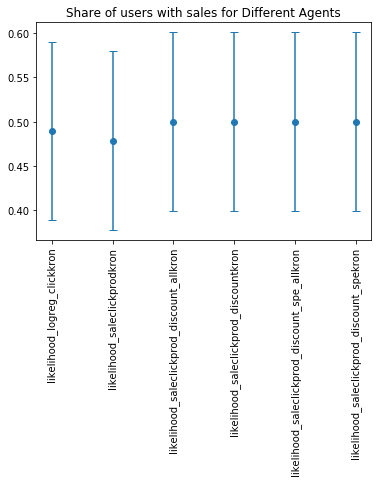

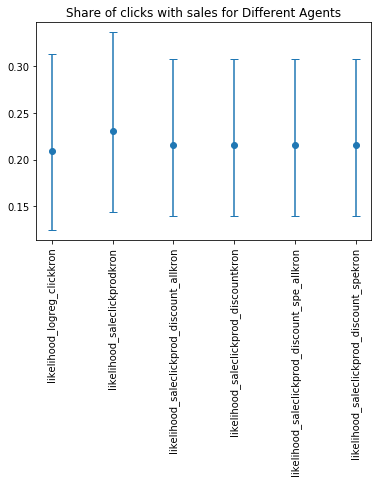

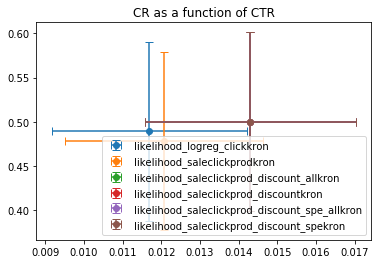

In [37]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [38]:
dico = res_dict[ 'rand100_90_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[4, 5, 8, 0, 7, 3, 6, 9, 2]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[4, 7, 0, 8, 5, 2, 9, 3, 6]
Length: 9, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[0]
Length: 1, dtype: UInt16


Kronecker features
Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.39s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.31s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [04:15<00:00,  2.56s/it]


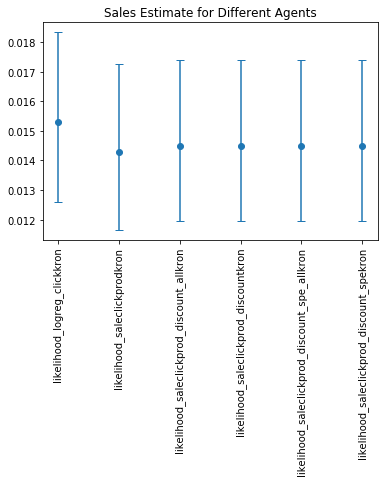

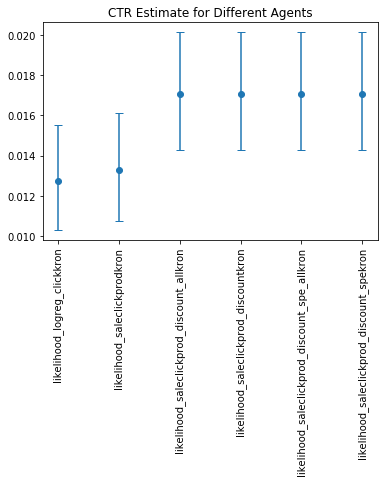

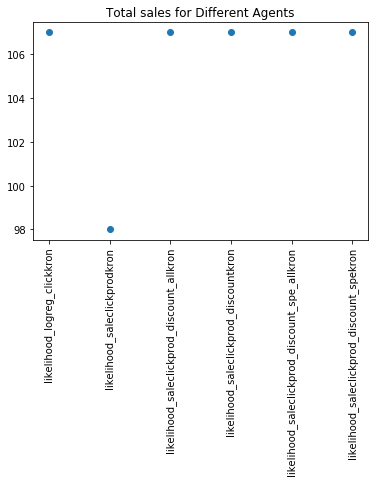

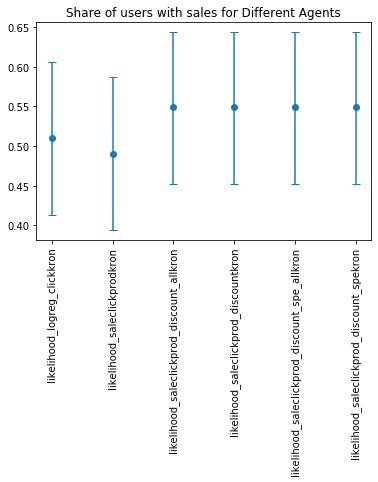

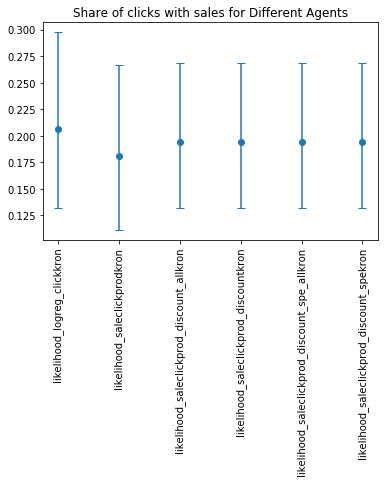

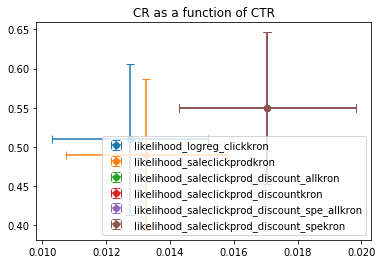

In [30]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [31]:
dico = res_dict[ 'rand100_100_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[3, 8, 5, 2, 7, 0, 6, 9, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[9, 5, 2, 7, 8, 0, 3, 6, 4]
Length: 9, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[0]
Length: 1, dtype: UInt16


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


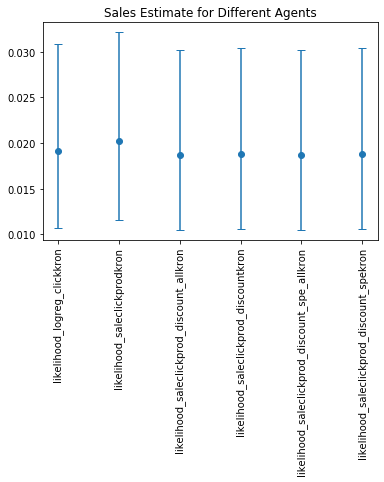

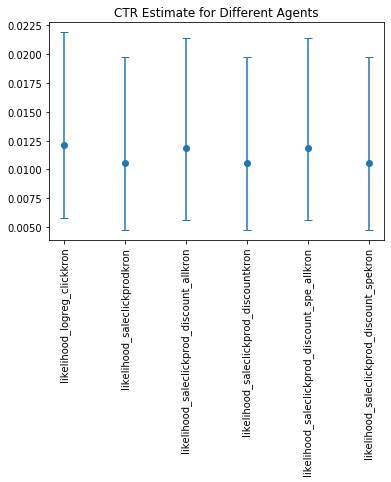

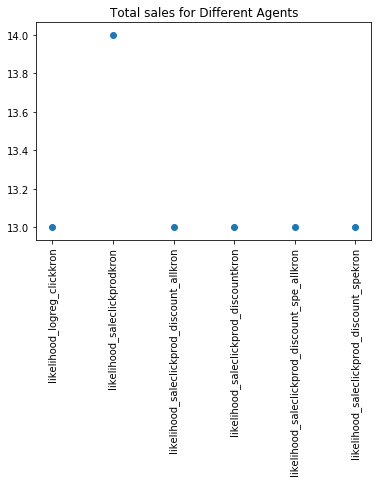

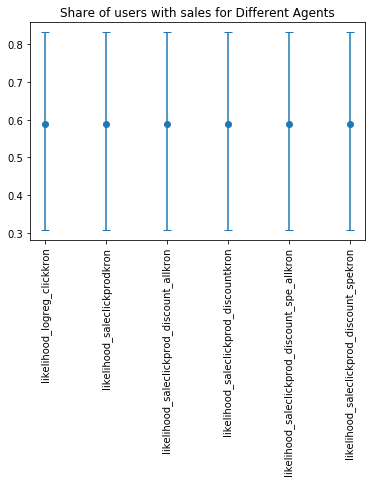

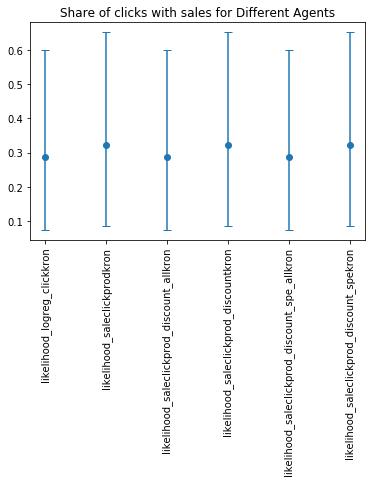

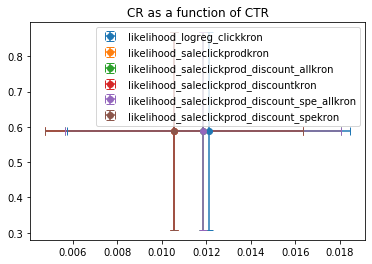

In [43]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [47]:
dico = res_dict[ 'rand1000_10_v_sharekron']
# display(dico['sale rate'])
# display(dico['CTR'])
# display(dico['Tot sales'])
# display(dico['Share user with sale'])
# display(dico['reco'])

for k in dico["reco"].keys():
    print(k)
    print(dico["reco"][k]["a"].unique())

likelihood_logreg_clickkron
<IntegerArray>
[5]
Length: 1, dtype: UInt16
likelihood_saleclickprodkron
<IntegerArray>
[4, 9, 5]
Length: 3, dtype: UInt16
likelihood_saleclickprod_discount_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discountkron
<IntegerArray>
[1, 9, 5, 7]
Length: 4, dtype: UInt16
likelihood_saleclickprod_discount_spe_allkron
<IntegerArray>
[0]
Length: 1, dtype: UInt16
likelihood_saleclickprod_discount_spekron
<IntegerArray>
[1, 9, 5, 7]
Length: 4, dtype: UInt16


In [ ]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
name_logging = 'likclickkron'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={**agents, **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+name_extension+".pkl","wb"))

### 1000 users in training and AB test

In [7]:
res_dict={}
name_extension='kron'

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [40:33<00:00,  2.43s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [51:38<00:00,  3.10s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:04:52<00:00,  3.89s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:05:57<00:00,  3.96s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [56:22<00:00,  3.38s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:31<00:00,  4.17s/it]


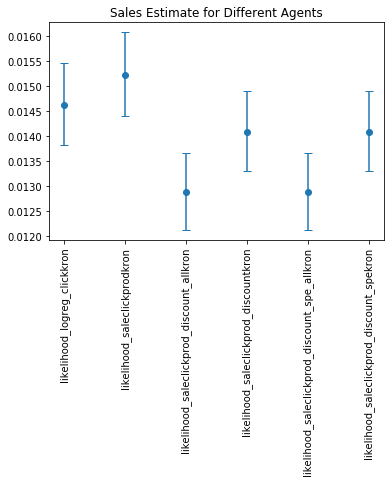

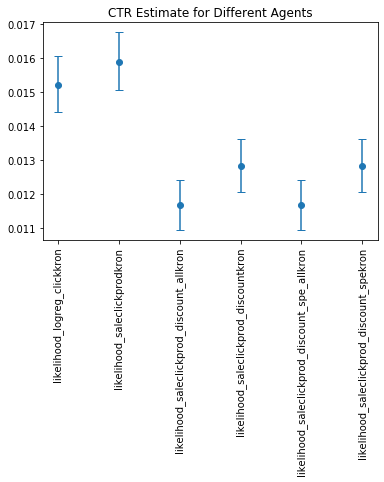

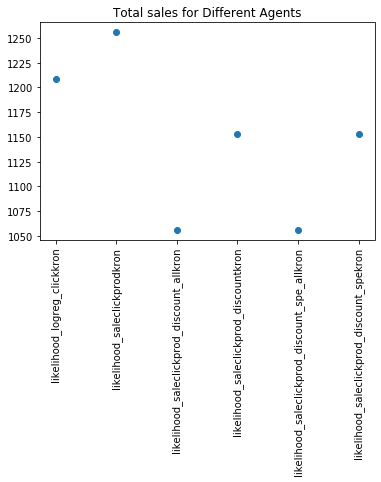

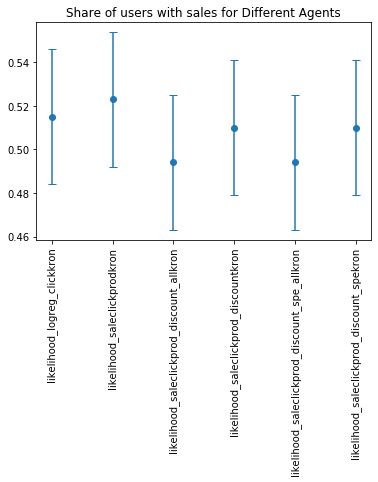

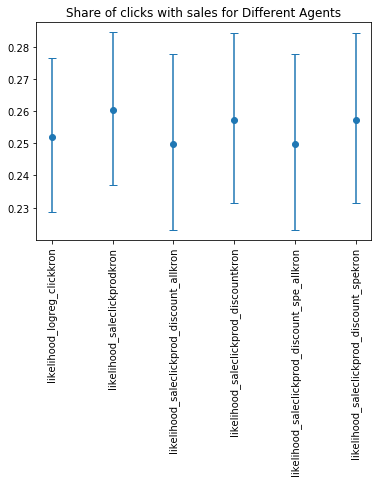

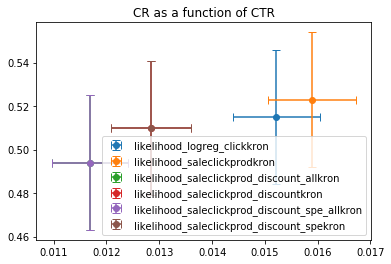

In [10]:
name_logging = 'rand'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [50:37<00:00,  3.04s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [1:08:17<00:00,  4.10s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [58:27<00:00,  3.51s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [58:19<00:00,  3.50s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [57:11<00:00,  3.43s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [58:00<00:00,  3.48s/it]


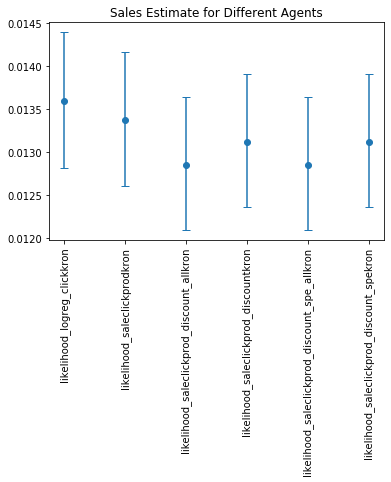

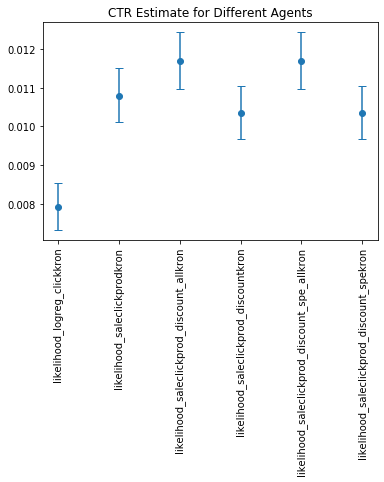

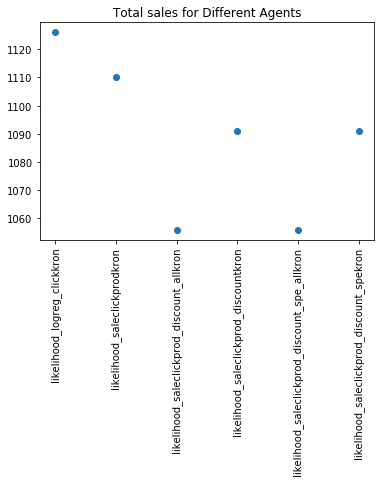

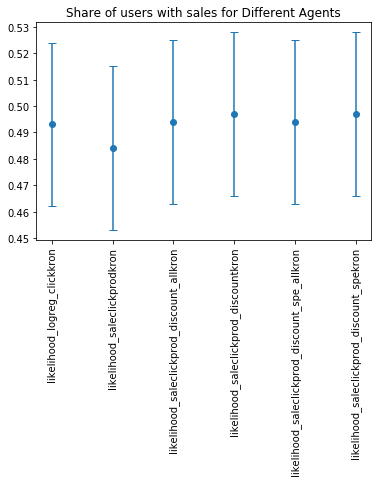

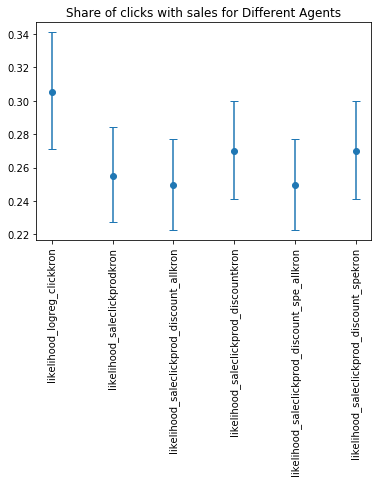

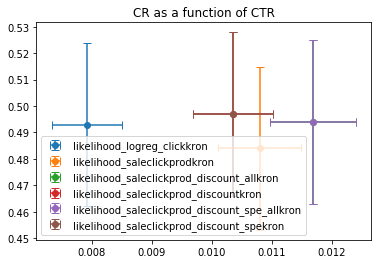

In [11]:
name_logging = 'organic'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
#         **agents, 
        **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.50it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.33it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [36:37<00:00,  2.20s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [48:44<00:00,  2.92s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [57:42<00:00,  3.46s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [57:25<00:00,  3.45s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

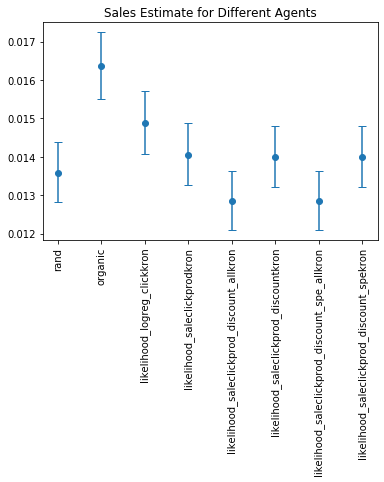

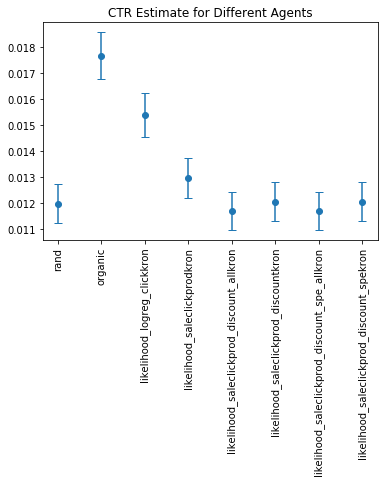

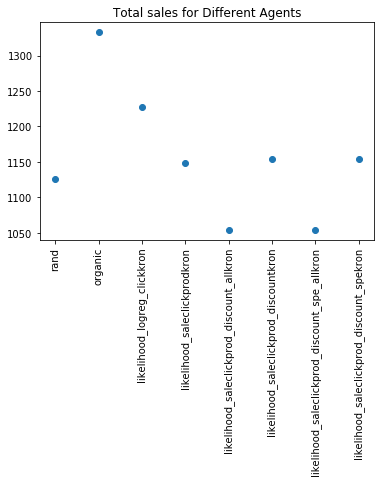

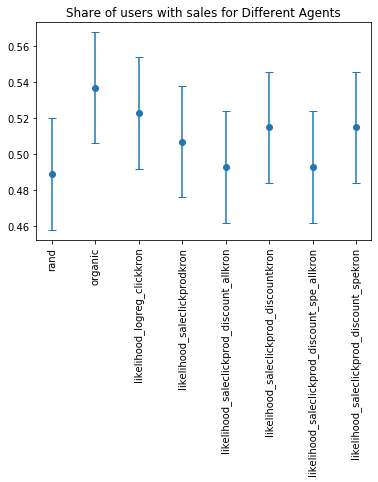

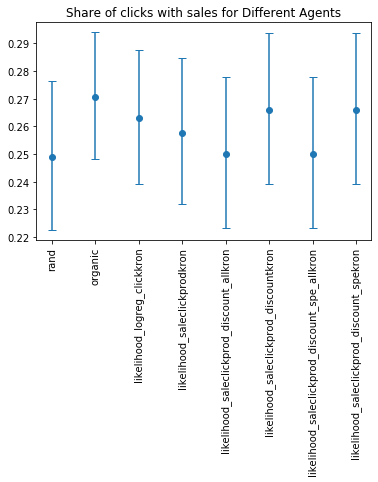

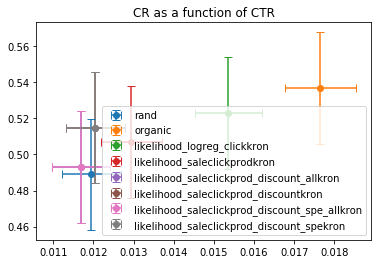

In [12]:
name_logging = 'likclickkron'
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/agents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_agents(name_logging,logs,feature_name,features, kronecker_features=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={**agents, **save_agents}
)

# save result
pkl.dump([res, env_1_sale_args, info, save_agents],
         open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

# plot result
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [13]:
pkl.dump(res_dict,
         open("data/res_dict"+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+"_"+str(len(res_dict))+name_extension+".pkl","wb"))